#Dense Model - Binary Dataset
# Deep Learning Medical Image Analysis
A dense neural network model trained using a simple pathology image dataset.

## Python Imports
This section will load the necessary python packages to the instance.

In [ ]:
from tensorflow import keras
keras.__version__

'2.12.0'

In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Dropout

## Dataset Downloader (PneumoniaMNIST)
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

### Here we are using the PneumoniaMNIST dataset

In [ ]:
DATA_NAME = "PneumoniaMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2023-04-11 12:13:12--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22841 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0.002s  

2023-04-11 12:13:12 (13.7 MB/s) - ‘info.py’ saved [22841/22841]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

4170669/4170669 [==============================] - 9s 2us/step


Here we normalize the input data images by dividing them by 255 becasue this is the maximum value a pixel can have depending on its lightness or darkness. This is done to achieve numerical stability. As the data range gets modified to [0,1], the weights are updated more efficiently and convergence happens faster. Also, the effect of irrelevant features gets reduced and the problem of vanishing gradient can be mitigated to a certain extent.  

In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"].astype('float32') / 255.0
train_y = dataset["train_labels"].astype('float32') / 255.0

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"].astype('float32') / 255.0
val_y = dataset["val_labels"].astype('float32') / 255.0

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"].astype('float32') / 255.0
test_y = dataset["test_labels"].astype('float32') / 255.0

Now we reshape the input data to match the expected shape by the network and also the dense neural network only accepts a 1D data.

In [ ]:
train_x = train_x.reshape((train_x.shape[0], 28*28))
val_x = val_x.reshape((val_x.shape[0], 28*28))
test_x = test_x.reshape((test_x.shape[0], 28*28))

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
print(labels)
# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

['normal', 'pneumonia', 'total']
           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


Now we convert the class labels to one-hot-encoded vectors which is necessary in multi-class classification problems.

In [ ]:
#Calculating the number of class labels
classes_num = (len(list(data["label"].values())))

#Converting class labels to one-hot-encoded vectors
train_y = keras.utils.to_categorical(dataset["train_labels"], num_classes=classes_num)
val_y = keras.utils.to_categorical(dataset["val_labels"], num_classes=classes_num)
test_y = keras.utils.to_categorical(dataset["test_labels"], num_classes=classes_num)

## Model Definition
In this section we will define the neural network arcitecture. We are supposed to only include dense layers here. Therefore, to match the number of parameters with the original models, we take the input layer of **16** units and the hidden layer of **16** units as well. This will give us around **13k parameters** which is quite close to the original model having about 19k parameters. The input and the hidden layer have **relu** as their activation function. The output layer is a **softmax** activation function as it outputs the probability of each data point to belong to one of the class labels.

We are using **binary crossentropy** as our loss function as this is ideal function for binary classification problems.

We will keep **SGD** as our optimizer in all our models so that we can compare all the models.

In [ ]:
# Define the model architecture
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu', input_shape=(28*28,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(classes_num, activation='softmax'))

# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)

# Compile the model
model.compile(optimizer=optimiser, loss='binary_crossentropy', metrics=['accuracy', "AUC", "Precision", "Recall"])

In [ ]:
# Build the model
model.build(input_shape=(None, 784))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.


In [ ]:
history = model.fit(train_x,
                    train_y,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_x, val_y)
                    )

Epoch 1/10
74/74 [==============================] - 7s 10ms/step - loss: 0.5848 - accuracy: 0.7421 - auc: 0.7656 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5712 - val_accuracy: 0.7424 - val_auc: 0.7885 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 2/10
74/74 [==============================] - 0s 5ms/step - loss: 0.5628 - accuracy: 0.7421 - auc: 0.8081 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5620 - val_accuracy: 0.7424 - val_auc: 0.8040 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 3/10
74/74 [==============================] - 0s 5ms/step - loss: 0.5557 - accuracy: 0.7421 - auc: 0.8230 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5564 - val_accuracy: 0.7424 - val_auc: 0.8157 - val_precision: 0.7424 - val_recall: 0.7424
Epoch 4/10
74/74 [==============================] - 0s 5ms/step - loss: 0.5503 - accuracy: 0.7421 - auc: 0.8344 - precision: 0.7421 - recall: 0.7421 - val_loss: 0.5515 - val_accuracy: 0.7424 - val_auc: 0.8289 - val_precision: 0.7424 - va

## Plot Learning Curves
This is where we visualise the training of the model.

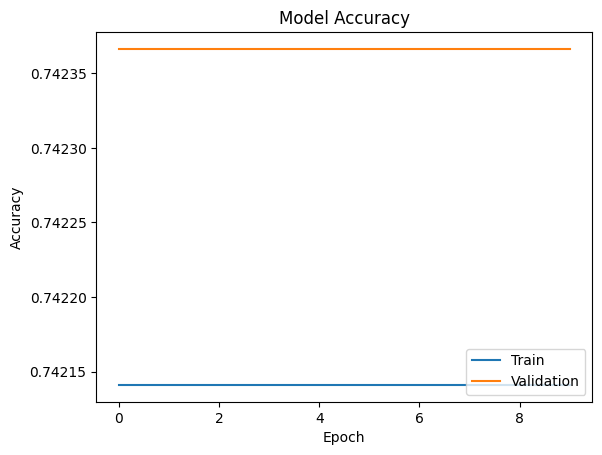

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

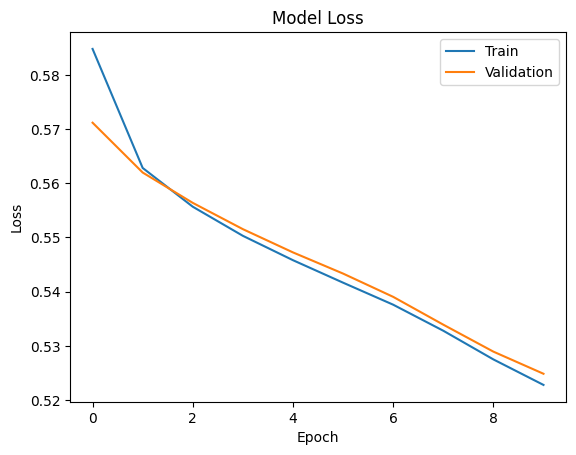

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

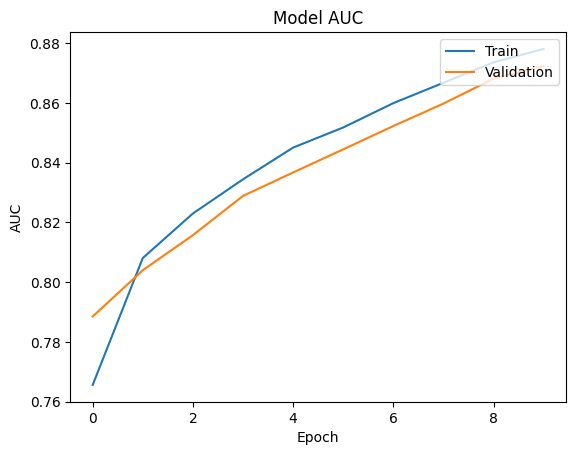

In [ ]:
# Plots the training and validation AUC over the number of epochs.
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

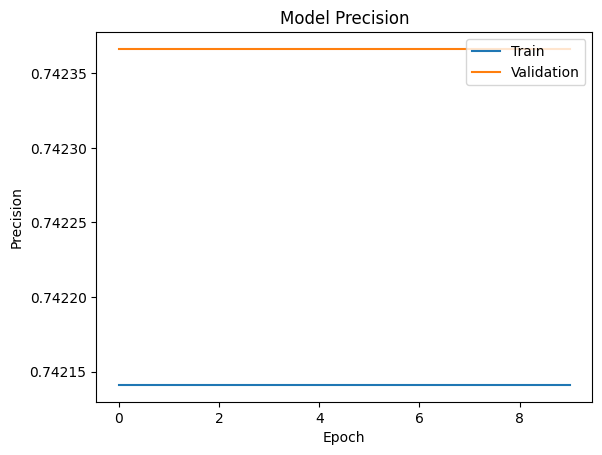

In [ ]:
# Plots the training and validation precision over the number of epochs.
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

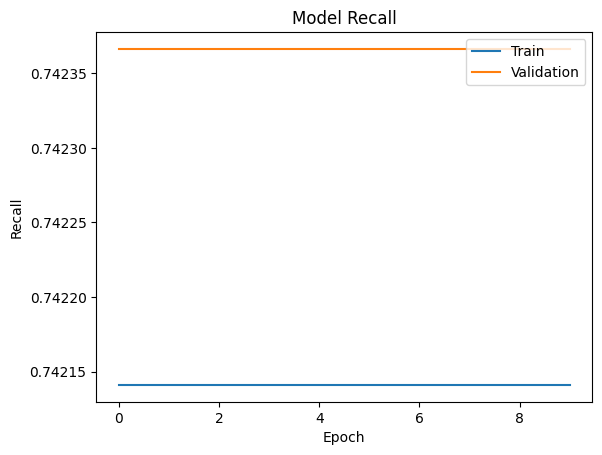

In [ ]:
# Plots the training and validation recall over the number of epochs.
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(test_x, test_y)

20/20 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.6250 - auc: 0.7647 - precision: 0.6250 - recall: 0.6250


In [ ]:
print("PneumoniaMNIST\n" + "Loss - " + str(test_loss) + "\n" + "Accuracy - " + str(test_acc) + "\n" + "AUC - " + str(test_auc) + "\n" + "Precision - " + str(test_precision) + "\n" + "Recall - " + str(test_recall))

PneumoniaMNIST
Loss - 0.6507357954978943
Accuracy - 0.625
AUC - 0.7647312879562378
Precision - 0.625
Recall - 0.625
